In [8]:
# import statements
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xrscipy.signal as dsp
import xrscipy.signal.extra as dsp_extra
from scipy.ndimage import gaussian_filter

import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
# function because some of the simulations have a messed-up calendar
def preprocess(ds_in: xr.Dataset) -> xr.Dataset:
    ds_in.XTIME.attrs["units"] = "minutes since 2021-09-01 23:00:00"
    ds_in.XTIME.attrs["description"] = "minutes since 2021-09-01 23:00:00"
    return(ds_in)

def load(var: str, init_time: str, ens_num: int):
    path = "/mnt/drive2/wof-runs/"+init_time+"/"+var+"/wrfwof*.{:02d}".format(ens_num)
    return(xr.open_mfdataset(path,preprocess=preprocess,
                          decode_times=False,combine="nested",
                          concat_dim="Time")
    )
def fix_xtime(ds_in: xr.Dataset,init_time: str) -> xr.Dataset:
    if init_time in ["20", "21", "22", "23"]:
        start_date = "2021-09-01"
    elif init_time in ["00", "01", "02"]:
        start_date = "2021-09-02"
    else:
        raise ValueError("Unexpected init_time provided.")
    ds_in.XTIME.attrs["units"] = "minutes since "+start_date+" "+init_time+":00:00"
    ds_in.XTIME.attrs["description"] = ("minutes since "+start_date+" "+
                                        init_time+":00:00")
    return(xr.decode_cf(ds_in))

In [3]:
print("21Z")
mslp_21Z = xr.concat([fix_xtime(load("MSLP","21Z",e),"21") for e in range(1,19)],
                       "ens").MSLP
print("22Z")
mslp_22Z = xr.concat([fix_xtime(load("MSLP","22Z",e),"22") for e in range(1,19)],
                       "ens").MSLP
print("23Z")
mslp_23Z = xr.concat([fix_xtime(load("MSLP","23Z",e),"23") for e in range(1,19)],
                       "ens").MSLP
print("00Z")
mslp_00Z = xr.concat([fix_xtime(load("MSLP","00Z",e),"00") for e in range(1,19)],
                       "ens").MSLP

21Z
22Z
23Z
00Z


In [55]:
def get_time(ds_in: xr.DataArray, time: str) -> xr.DataArray:
    return(ds_in.isel(Time=abs(ds_in.XTIME - np.datetime64(
        pd.to_datetime(time))).argmin()))

In [56]:
lat = mslp_21Z.XLAT.isel(Time=0)
lon = mslp_21Z.XLONG.isel(Time=0)

In [57]:
# get central latitude and longitude for projections
central_latitude = float(lat.mean())
central_longitude = float(lon.mean())

mslp_list = [
    mslp_21Z,mslp_22Z,mslp_23Z,mslp_00Z
    ]

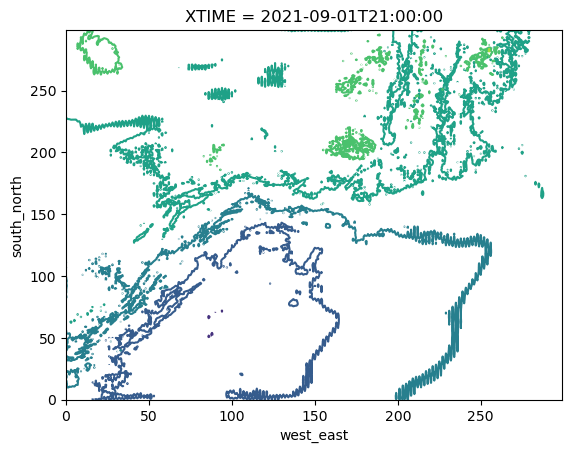

In [22]:
mslp_21Z.mean(dim="ens").isel(Time=0).plot.contour()

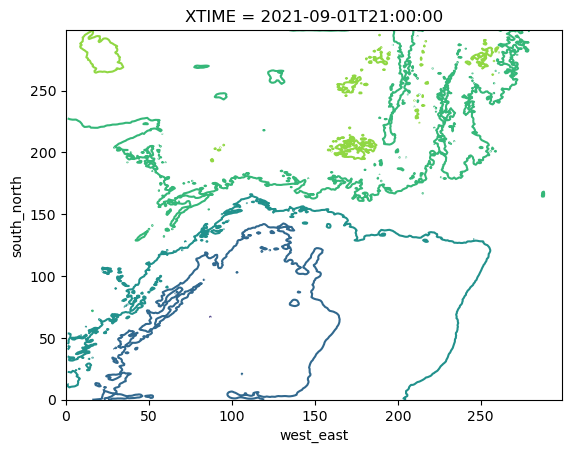

In [5]:
mslp_21Z.mean(dim="ens").isel(Time=0).rolling(west_east=2,center=True).mean().plot.contour()

In [25]:
sigma = 1.0

filtered = mslp_21Z.to_dataset().apply(gaussian_filter, sigma=sigma, axes=3)

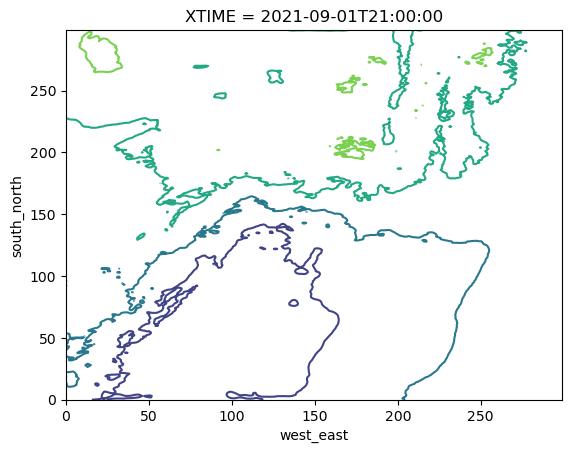

In [26]:
filtered.MSLP.mean(dim="ens").isel(Time=0).plot.contour()

In [52]:
filtered2 = dsp_extra.lowpass(mslp_21Z.load(),f_cutoff=0.45,dim="west_east")

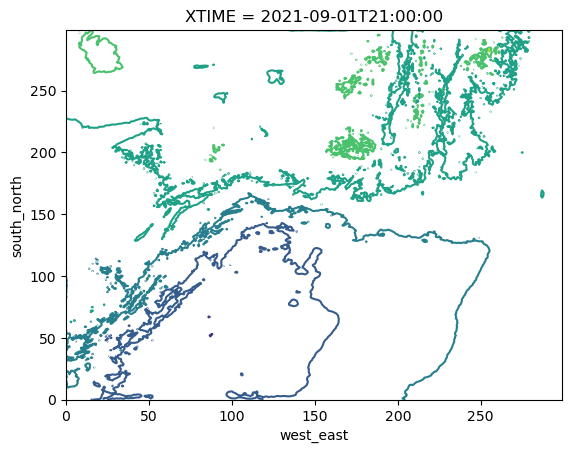

In [53]:
filtered2.mean(dim="ens").isel(Time=0).plot.contour()

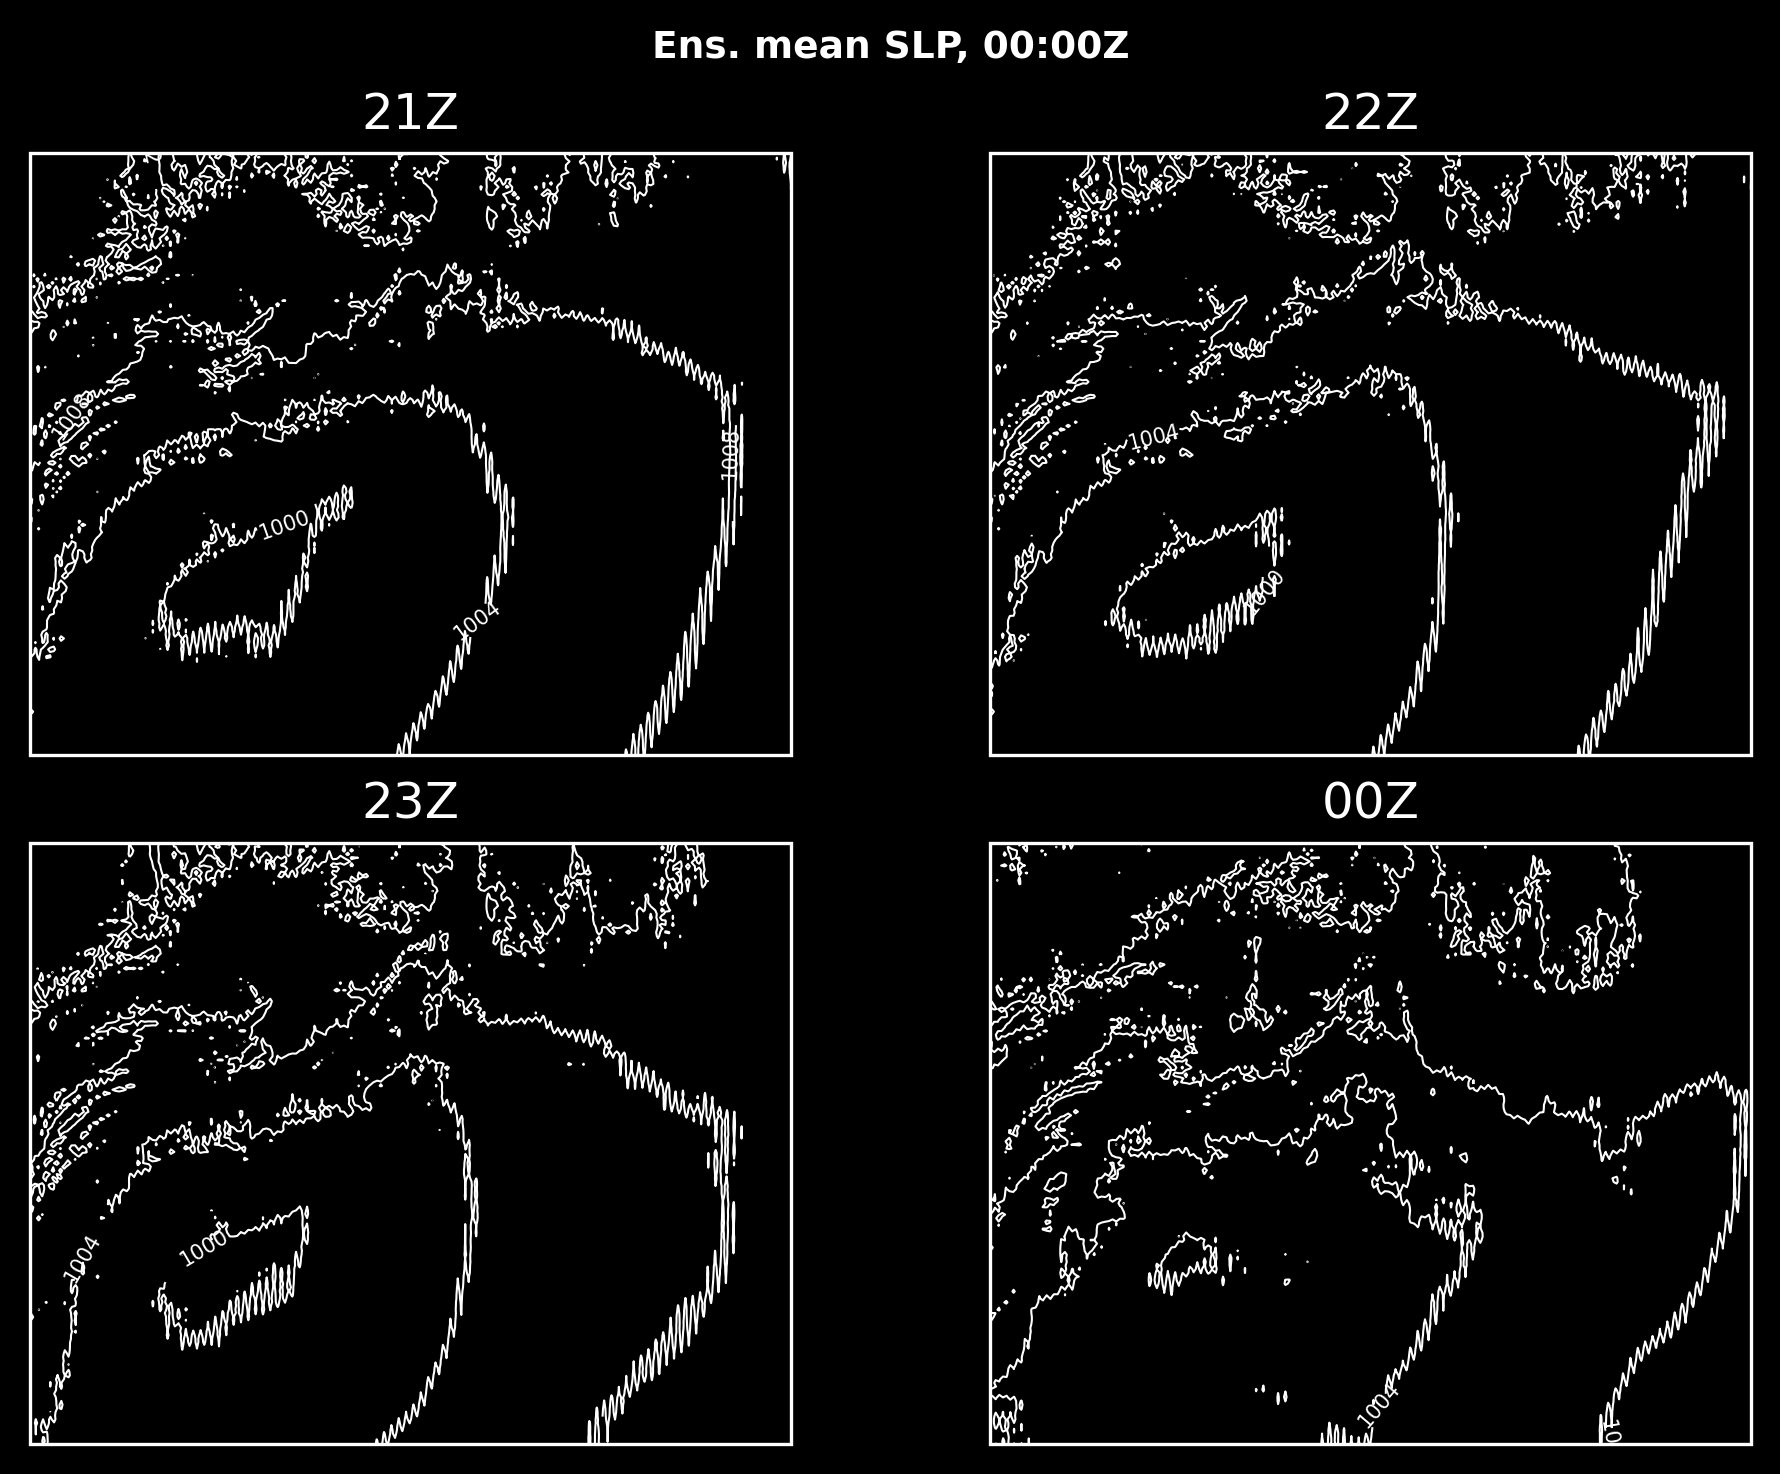

In [59]:
# define a few variables
linewidth=0.5
region = [-78,-70.7,38,42.5]
titles = ["21Z", "22Z", "23Z", "00Z"]

plt.style.use("dark_background")

# Get data to plot
data_to_plot = [get_time(m,"2021-09-02 00:00:00").squeeze().mean(
    dim="ens"
) for m in mslp_list]

proj = ccrs.LambertConformal(central_longitude=central_longitude,
                             central_latitude=central_latitude)

fig, axes = plt.subplots(2, 2, subplot_kw=dict(projection=proj),
                         dpi=300,layout="constrained")

for i,ax in enumerate(axes.flatten()):
    c = ax.contour(
        lon,lat,data_to_plot[i]/100,
        transform=ccrs.PlateCarree(),
        colors="white",
        levels=np.arange(996,1025,4),
        linewidths=0.5
    )
    ax.clabel(c,c.levels,inline=True,fontsize=5)
    c.axes.set_extent(region,crs=ccrs.PlateCarree())
    c.axes.add_feature(cfeature.STATES,linewidth=linewidth)
    ax.set_title(titles[i])

# plt.subplots_adjust(wspace=0.04,hspace=0.04)
plt.suptitle("Ens. mean SLP, 00:00Z",fontsize=9,fontweight='bold')
# cbar = fig.colorbar(c,ax=axes,shrink=0.8,aspect=30)
# cbar.ax.tick_params(labelsize=7)
# cbar.set_label("hPa",fontsize=8)
plt.show()

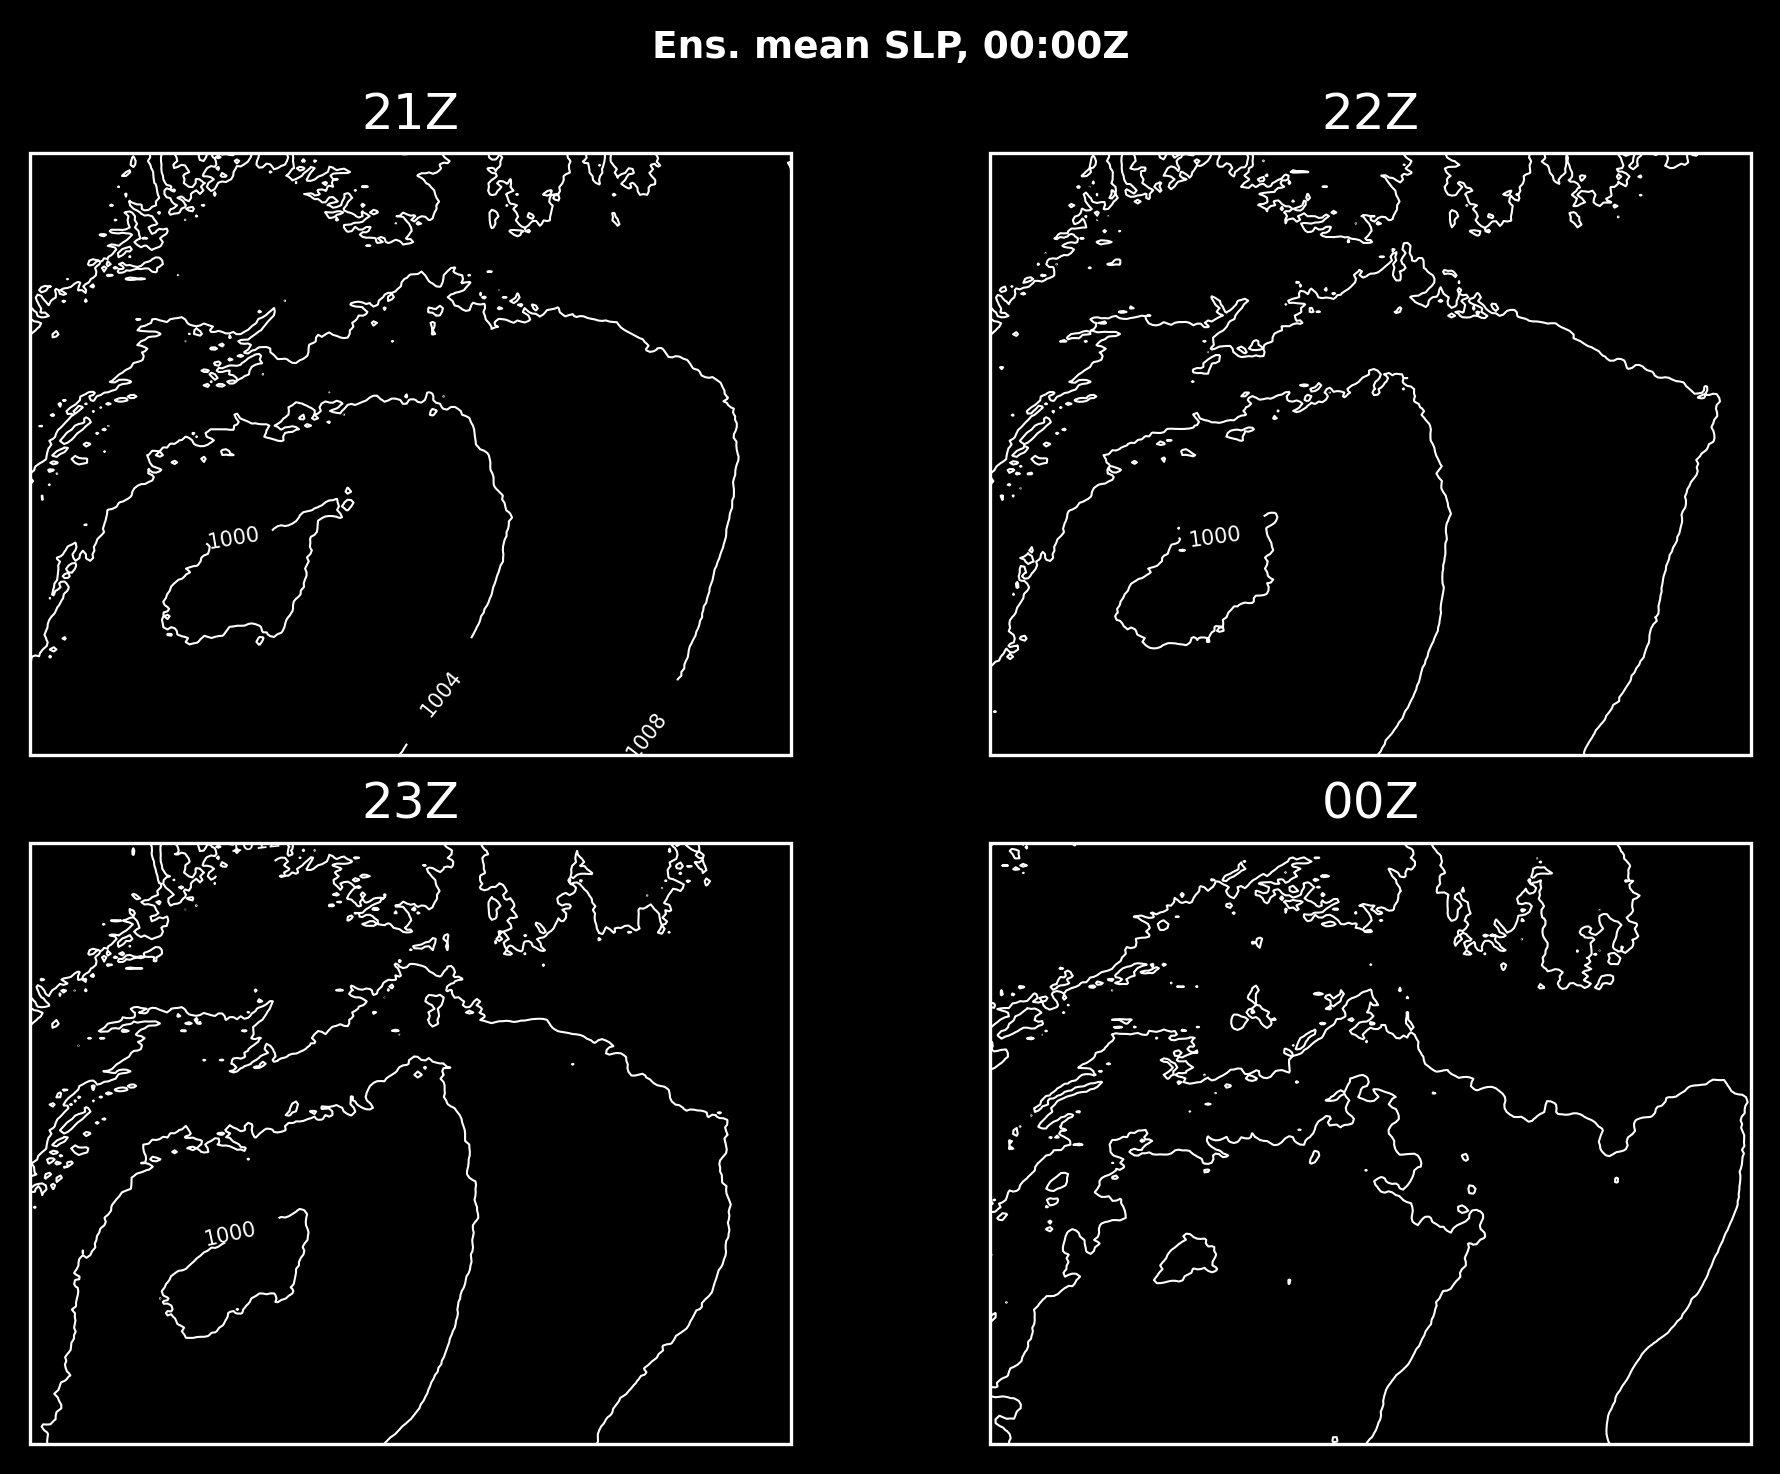

In [61]:
# define a few variables
linewidth=0.5
region = [-78,-70.7,38,42.5]
titles = ["21Z", "22Z", "23Z", "00Z"]

plt.style.use("dark_background")

# Get data to plot
data_to_plot_smoothed = [d.rolling(west_east=2,center=True).mean() 
                for d in data_to_plot]

proj = ccrs.LambertConformal(central_longitude=central_longitude,
                             central_latitude=central_latitude)

fig, axes = plt.subplots(2, 2, subplot_kw=dict(projection=proj),
                         dpi=300,layout="constrained")

for i,ax in enumerate(axes.flatten()):
    c = ax.contour(
        lon,lat,data_to_plot_smoothed[i]/100,
        transform=ccrs.PlateCarree(),
        colors="white",
        levels=np.arange(996,1025,4),
        linewidths=0.5
    )
    ax.clabel(c,c.levels,inline=True,fontsize=5)
    c.axes.set_extent(region,crs=ccrs.PlateCarree())
    c.axes.add_feature(cfeature.STATES,linewidth=linewidth)
    ax.set_title(titles[i])

# plt.subplots_adjust(wspace=0.04,hspace=0.04)
plt.suptitle("Ens. mean SLP, 00:00Z",fontsize=9,fontweight='bold')
# cbar = fig.colorbar(c,ax=axes,shrink=0.8,aspect=30)
# cbar.ax.tick_params(labelsize=7)
# cbar.set_label("hPa",fontsize=8)
plt.show()

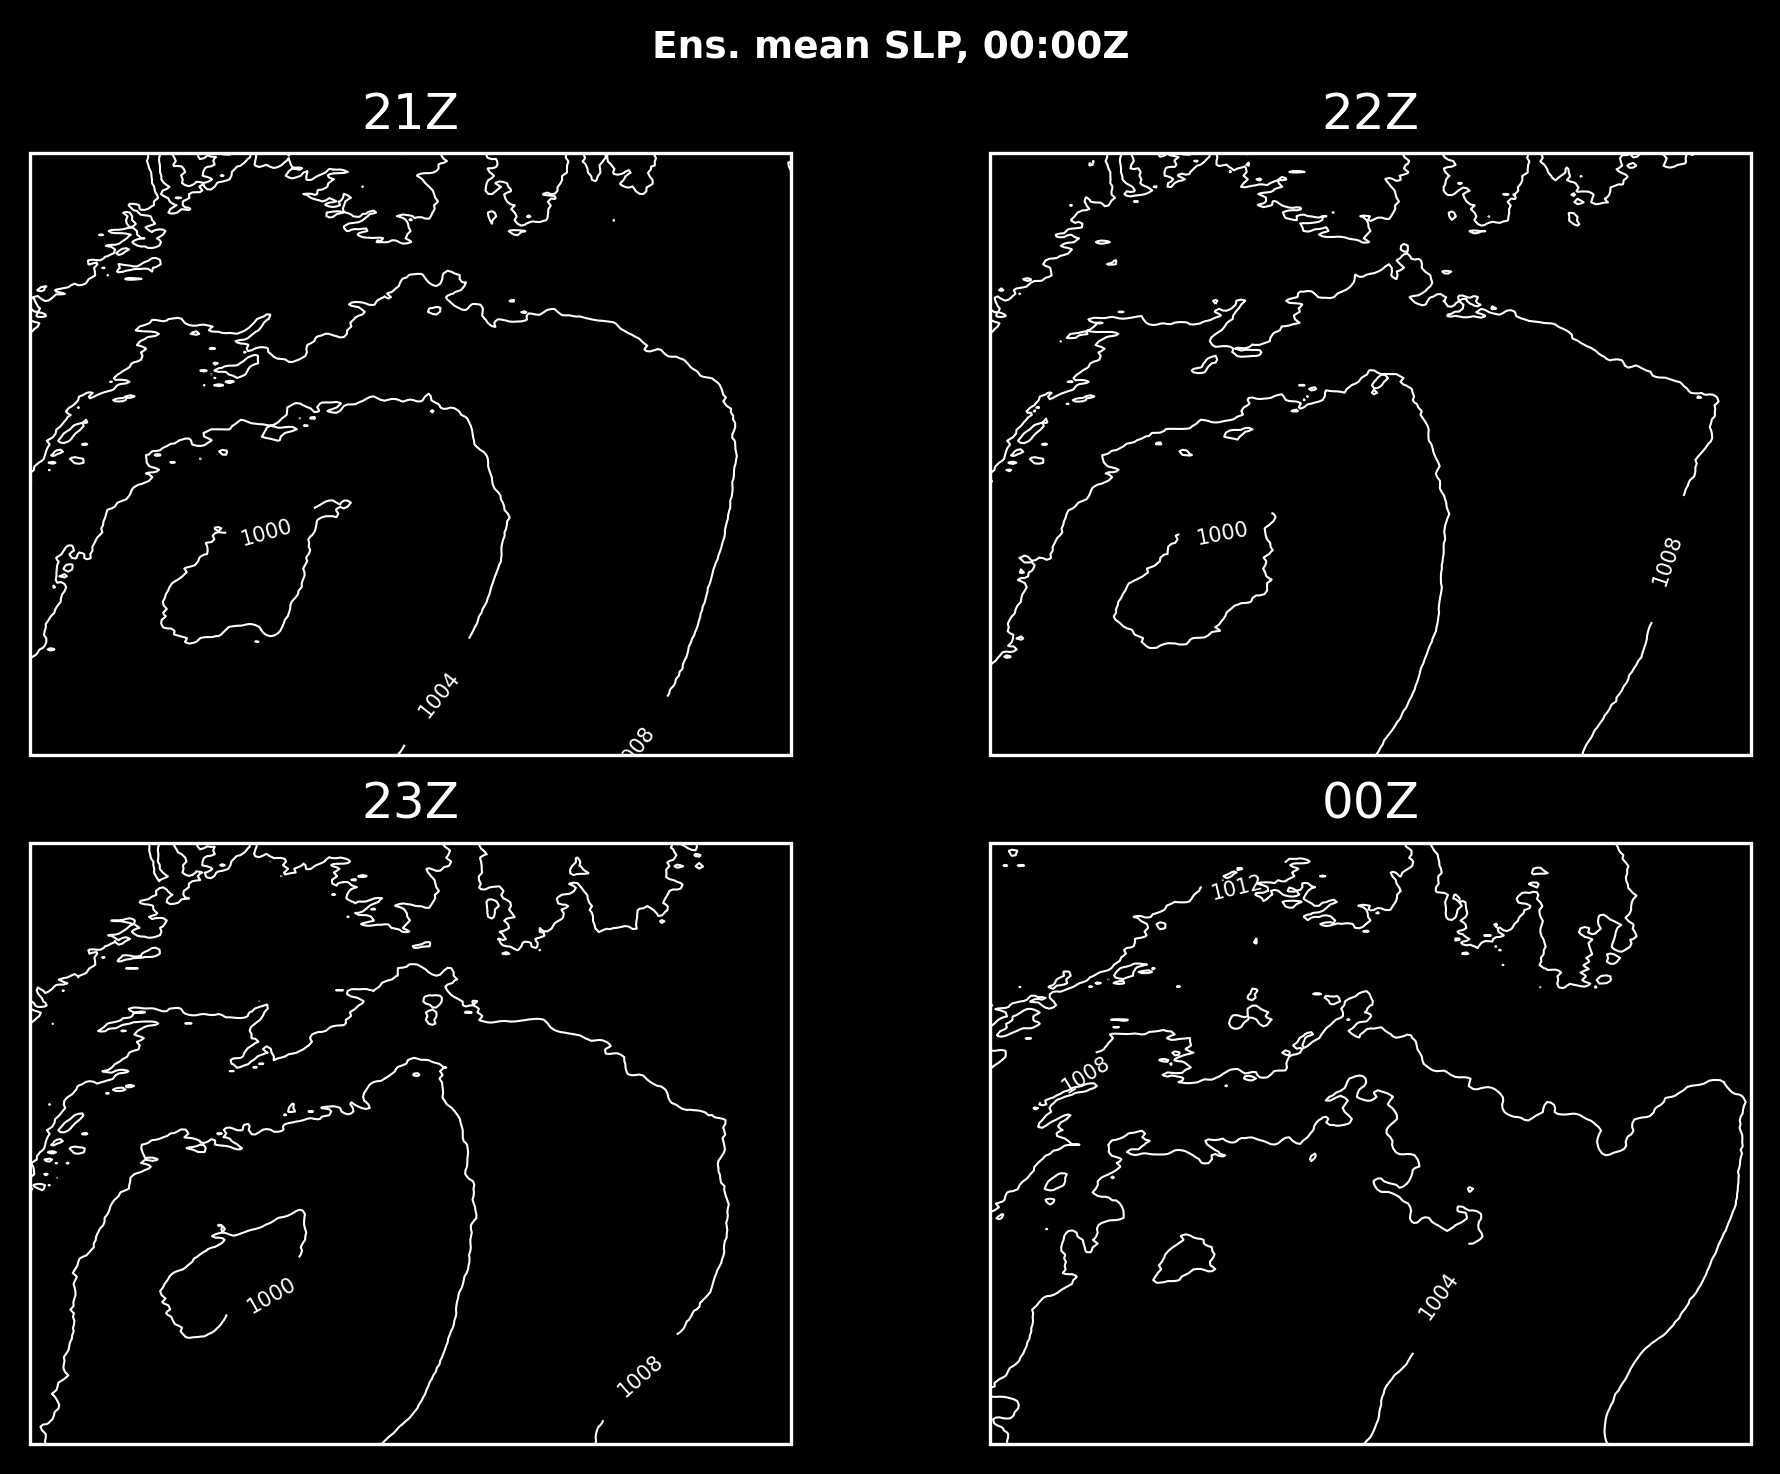

In [64]:
# define a few variables
linewidth=0.5
region = [-78,-70.7,38,42.5]
titles = ["21Z", "22Z", "23Z", "00Z"]

plt.style.use("dark_background")

# Get data to plot
data_to_plot_smoothed = [d.to_dataset().apply(gaussian_filter, sigma=sigma, axes=1) 
                for d in data_to_plot]

proj = ccrs.LambertConformal(central_longitude=central_longitude,
                             central_latitude=central_latitude)

fig, axes = plt.subplots(2, 2, subplot_kw=dict(projection=proj),
                         dpi=300,layout="constrained")

for i,ax in enumerate(axes.flatten()):
    c = ax.contour(
        lon,lat,data_to_plot_smoothed[i].MSLP/100,
        transform=ccrs.PlateCarree(),
        colors="white",
        levels=np.arange(996,1025,4),
        linewidths=0.5
    )
    ax.clabel(c,c.levels,inline=True,fontsize=5)
    c.axes.set_extent(region,crs=ccrs.PlateCarree())
    c.axes.add_feature(cfeature.STATES,linewidth=linewidth)
    ax.set_title(titles[i])

# plt.subplots_adjust(wspace=0.04,hspace=0.04)
plt.suptitle("Ens. mean SLP, 00:00Z",fontsize=9,fontweight='bold')
# cbar = fig.colorbar(c,ax=axes,shrink=0.8,aspect=30)
# cbar.ax.tick_params(labelsize=7)
# cbar.set_label("hPa",fontsize=8)
plt.show()

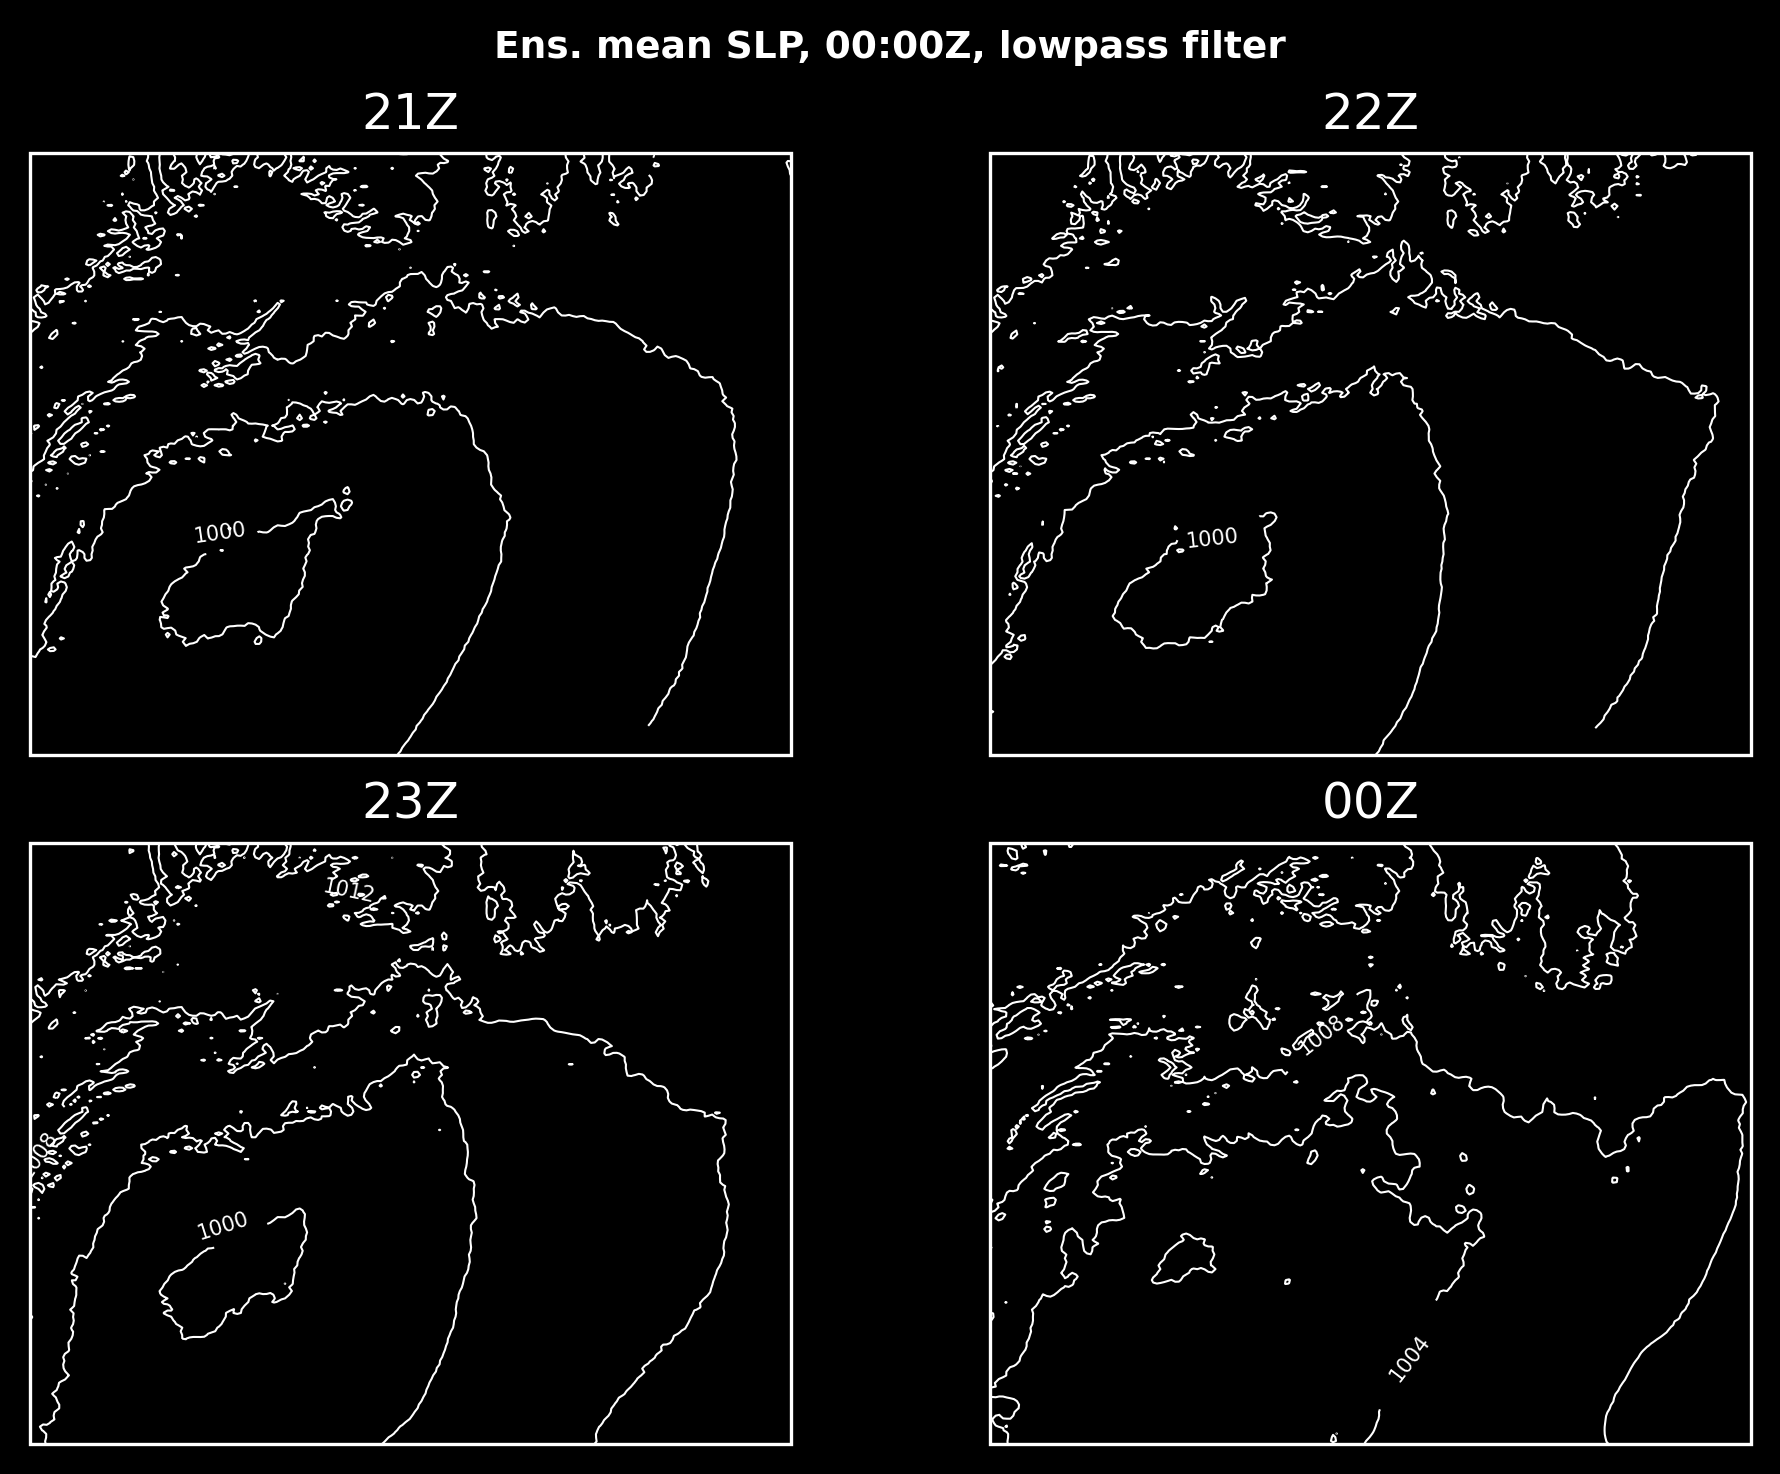

In [67]:
# define a few variables
linewidth=0.5
region = [-78,-70.7,38,42.5]
titles = ["21Z", "22Z", "23Z", "00Z"]

plt.style.use("dark_background")

# Get data to plot
data_to_plot_smoothed = [dsp_extra.lowpass(d.load(),f_cutoff=0.3,dim="west_east")
                         for d in data_to_plot]

proj = ccrs.LambertConformal(central_longitude=central_longitude,
                             central_latitude=central_latitude)

fig, axes = plt.subplots(2, 2, subplot_kw=dict(projection=proj),
                         dpi=300,layout="constrained")

for i,ax in enumerate(axes.flatten()):
    c = ax.contour(
        lon,lat,data_to_plot_smoothed[i]/100,
        transform=ccrs.PlateCarree(),
        colors="white",
        levels=np.arange(996,1025,4),
        linewidths=0.5
    )
    ax.clabel(c,c.levels,inline=True,fontsize=5)
    c.axes.set_extent(region,crs=ccrs.PlateCarree())
    c.axes.add_feature(cfeature.STATES,linewidth=linewidth)
    ax.set_title(titles[i])

# plt.subplots_adjust(wspace=0.04,hspace=0.04)
plt.suptitle("Ens. mean SLP, 00:00Z, lowpass filter",fontsize=9,fontweight='bold')
# cbar = fig.colorbar(c,ax=axes,shrink=0.8,aspect=30)
# cbar.ax.tick_params(labelsize=7)
# cbar.set_label("hPa",fontsize=8)
plt.show()

In [41]:
mslp_21Z.dims

('ens', 'Time', 'south_north', 'west_east')

In [ ]:
# define a few variables
linewidth=0.5
region = [-78,-70.7,38,42.5]
titles = ["21Z", "22Z", "23Z", "00Z"]

plt.style.use("dark_background")

# Get data to plot
data_to_plot = [get_time(m,"2021-09-02 00:00:00").squeeze().mean(
    dim="ens"
) for m in mslp_list]

proj = ccrs.LambertConformal(central_longitude=central_longitude,
                             central_latitude=central_latitude)

fig, axes = plt.subplots(2, 2, subplot_kw=dict(projection=proj),
                         dpi=300,layout="constrained")

for i,ax in enumerate(axes.flatten()):
    c = ax.contourf(
        lon,lat,data_to_plot[i]/100,
        transform=ccrs.PlateCarree(),cmap='viridis',
        levels=np.arange(998,1025,2)
    )
    c.axes.set_extent(region,crs=ccrs.PlateCarree())
    c.axes.add_feature(cfeature.STATES,linewidth=linewidth)
    ax.set_title(titles[i])

plt.subplots_adjust(wspace=0.04,hspace=0.04)
plt.suptitle("Ens. mean SLP, 00:00Z",fontsize=9,fontweight='bold')
cbar = fig.colorbar(c,ax=axes,shrink=0.8,aspect=30)
cbar.ax.tick_params(labelsize=7)
cbar.set_label("hPa",fontsize=8)
plt.show()

/tmp/ipykernel_2081620/2198252112.py:27: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.04,hspace=0.04)


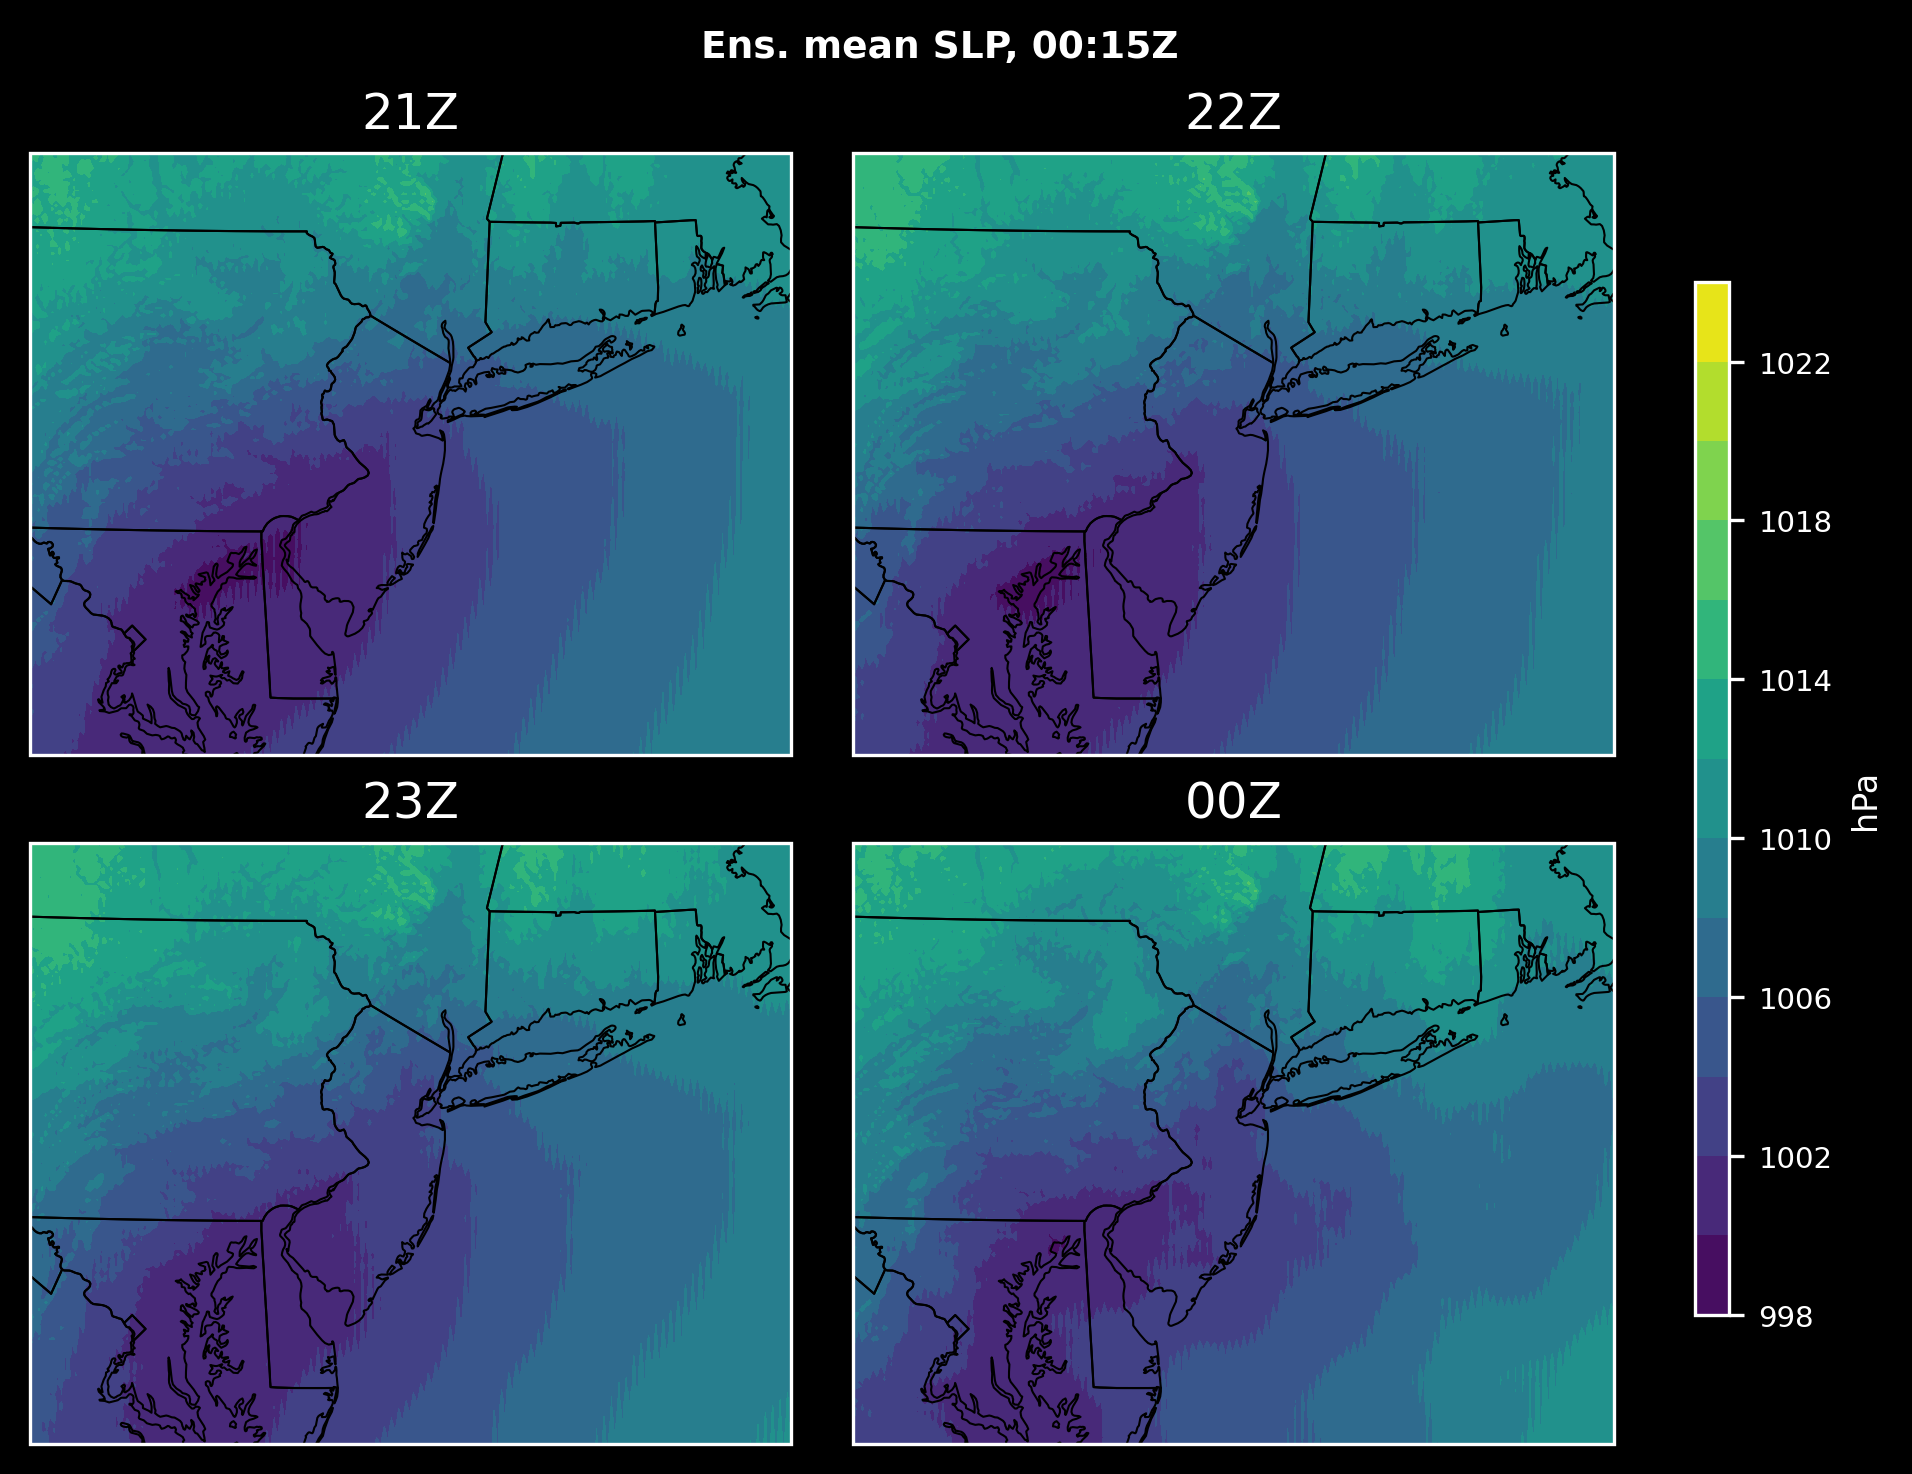

In [23]:
# define a few variables
linewidth=0.5
region = [-78,-70.7,38,42.5]
titles = ["21Z", "22Z", "23Z", "00Z"]

# Get data to plot
data_to_plot = [get_time(m,"2021-09-02 00:15:00").squeeze().mean(
    dim="ens"
) for m in mslp_list]

proj = ccrs.LambertConformal(central_longitude=central_longitude,
                             central_latitude=central_latitude)

fig, axes = plt.subplots(2, 2, subplot_kw=dict(projection=proj),
                         dpi=300,layout="constrained")

for i,ax in enumerate(axes.flatten()):
    c = ax.contourf(
        lon,lat,data_to_plot[i]/100,
        transform=ccrs.PlateCarree(),cmap='viridis',
        levels=np.arange(998,1025,2)
    )
    c.axes.set_extent(region,crs=ccrs.PlateCarree())
    c.axes.add_feature(cfeature.STATES,linewidth=linewidth)
    ax.set_title(titles[i])

plt.subplots_adjust(wspace=0.04,hspace=0.04)
plt.suptitle("Ens. mean SLP, 00:15Z",fontsize=9,fontweight='bold')
cbar = fig.colorbar(c,ax=axes,shrink=0.8,aspect=30)
cbar.ax.tick_params(labelsize=7)
cbar.set_label("hPa",fontsize=8)
plt.show()

/tmp/ipykernel_2081620/1085705050.py:27: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.04,hspace=0.04)


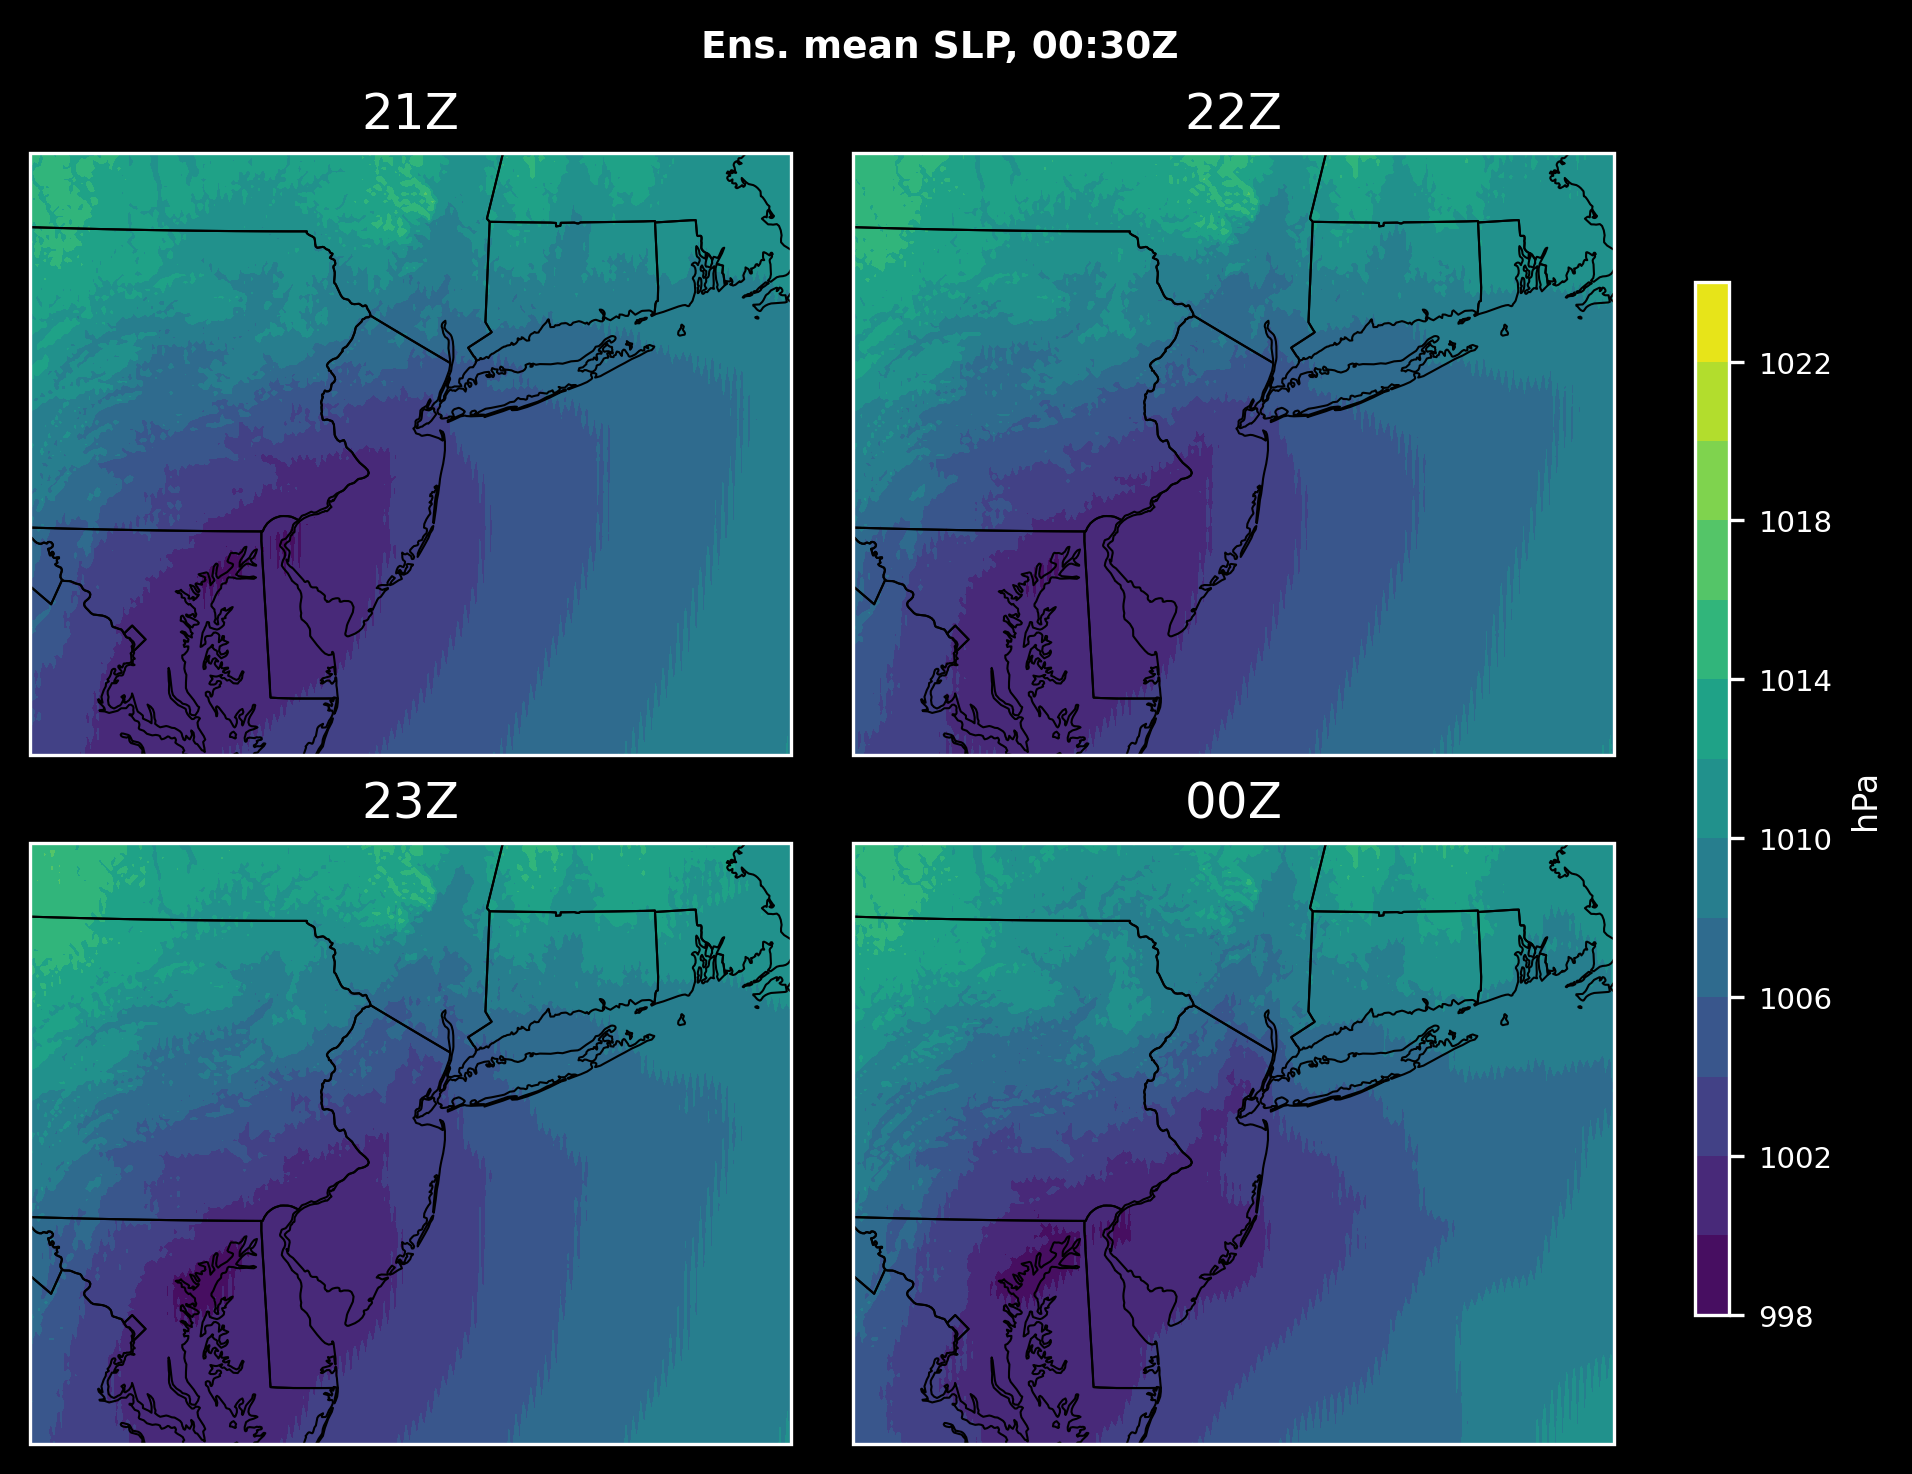

In [24]:
# define a few variables
linewidth=0.5
region = [-78,-70.7,38,42.5]
titles = ["21Z", "22Z", "23Z", "00Z"]

# Get data to plot
data_to_plot = [get_time(m,"2021-09-02 00:30:00").squeeze().mean(
    dim="ens"
) for m in mslp_list]

proj = ccrs.LambertConformal(central_longitude=central_longitude,
                             central_latitude=central_latitude)

fig, axes = plt.subplots(2, 2, subplot_kw=dict(projection=proj),
                         dpi=300,layout="constrained")

for i,ax in enumerate(axes.flatten()):
    c = ax.contourf(
        lon,lat,data_to_plot[i]/100,
        transform=ccrs.PlateCarree(),cmap='viridis',
        levels=np.arange(998,1025,2)
    )
    c.axes.set_extent(region,crs=ccrs.PlateCarree())
    c.axes.add_feature(cfeature.STATES,linewidth=linewidth)
    ax.set_title(titles[i])

plt.subplots_adjust(wspace=0.04,hspace=0.04)
plt.suptitle("Ens. mean SLP, 00:30Z",fontsize=9,fontweight='bold')
cbar = fig.colorbar(c,ax=axes,shrink=0.8,aspect=30)
cbar.ax.tick_params(labelsize=7)
cbar.set_label("hPa",fontsize=8)
plt.show()

/tmp/ipykernel_2081620/835010473.py:27: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.04,hspace=0.04)


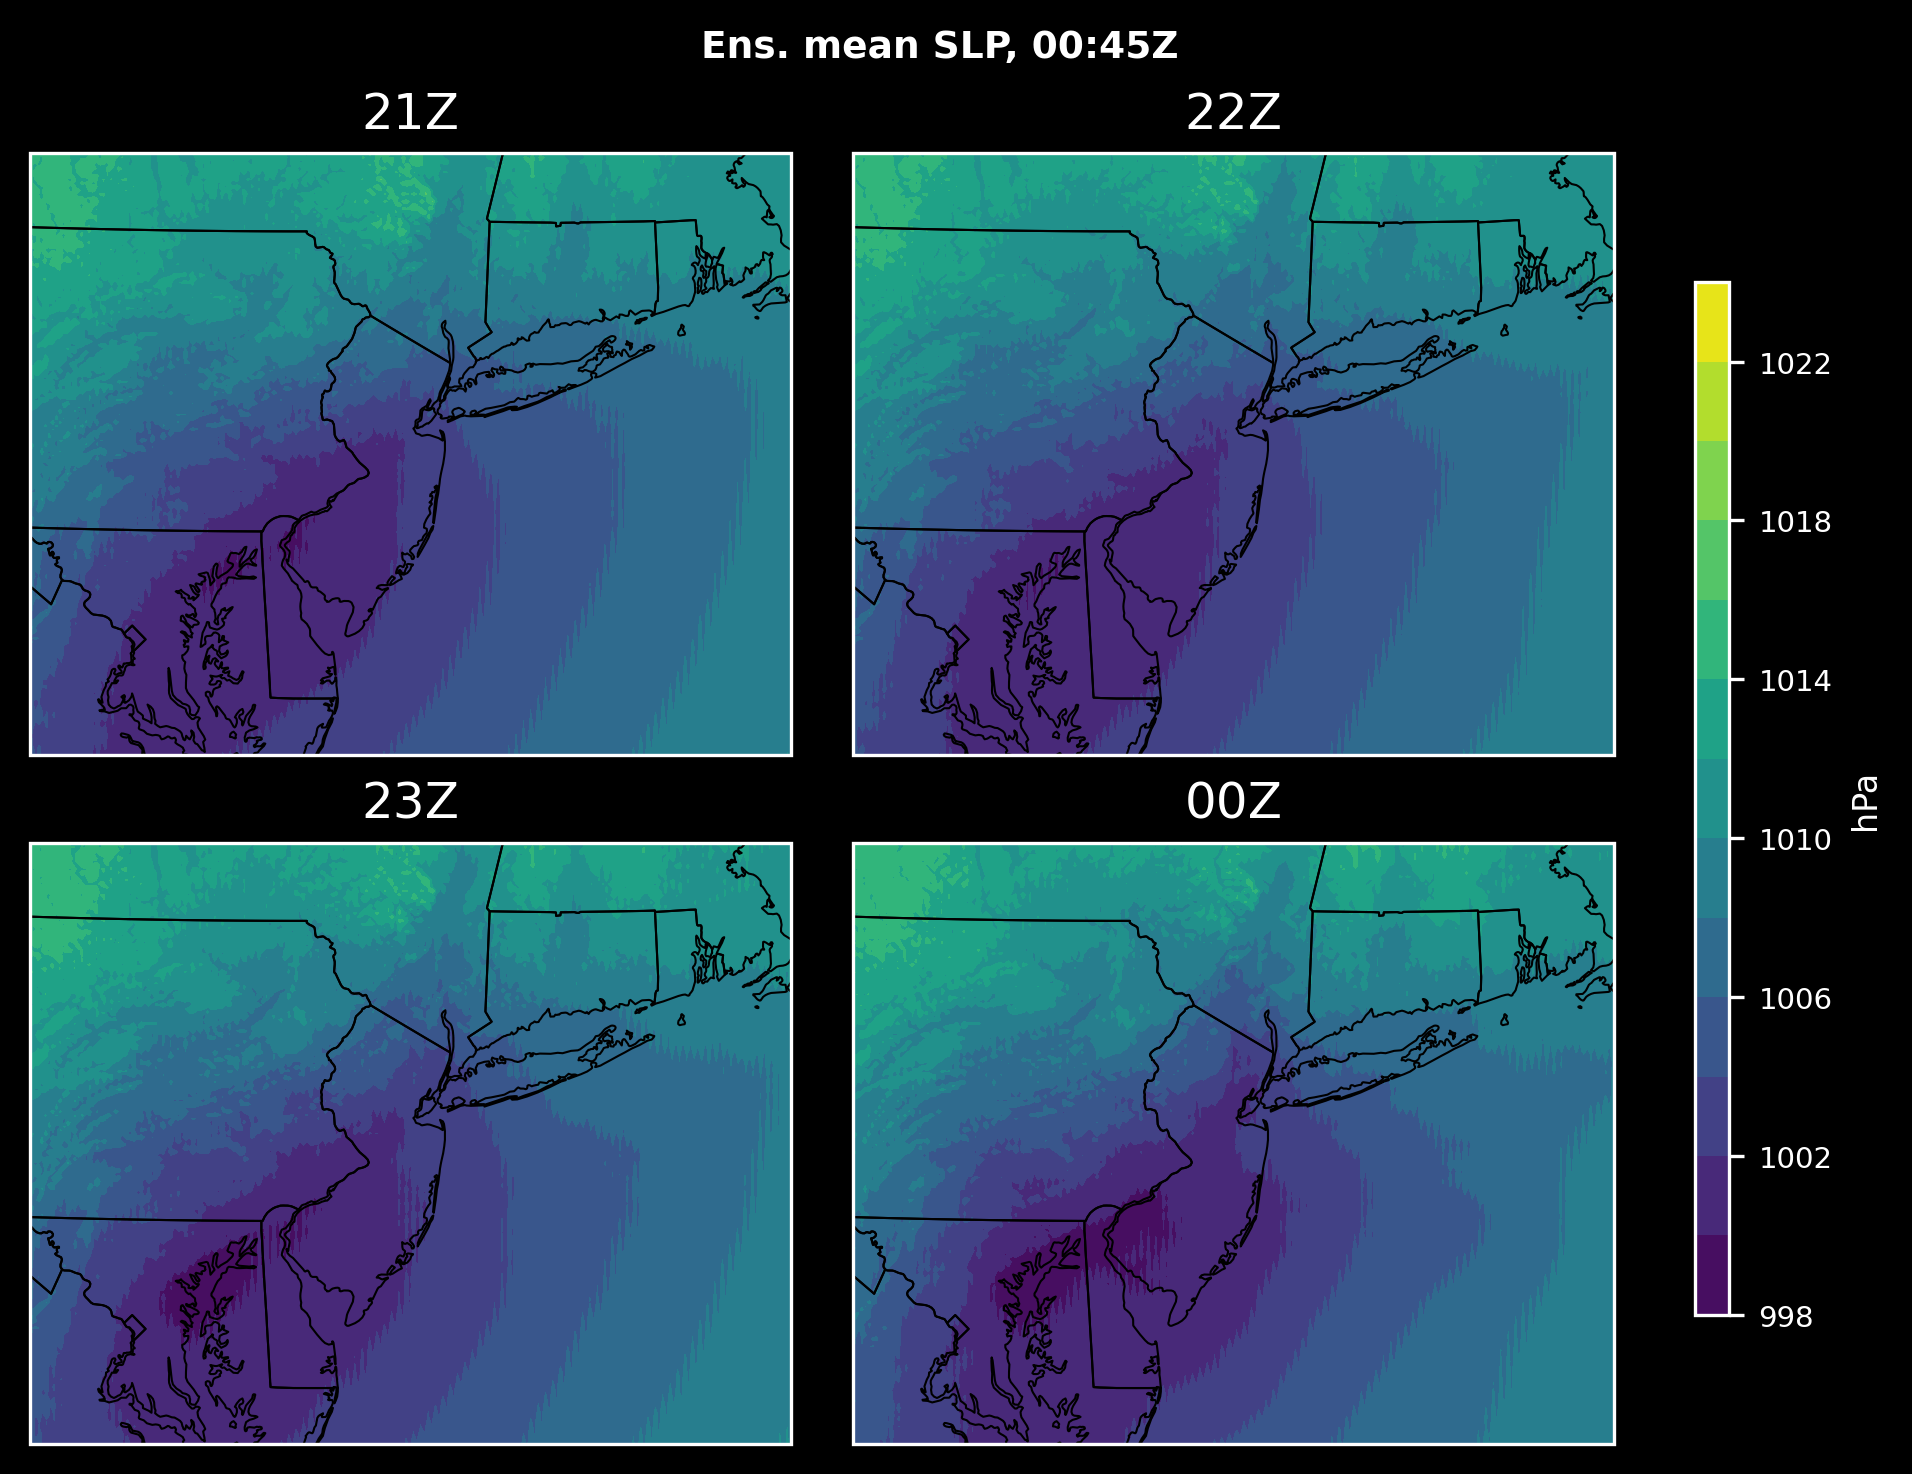

In [25]:
# define a few variables
linewidth=0.5
region = [-78,-70.7,38,42.5]
titles = ["21Z", "22Z", "23Z", "00Z"]

# Get data to plot
data_to_plot = [get_time(m,"2021-09-02 00:45:00").squeeze().mean(
    dim="ens"
) for m in mslp_list]

proj = ccrs.LambertConformal(central_longitude=central_longitude,
                             central_latitude=central_latitude)

fig, axes = plt.subplots(2, 2, subplot_kw=dict(projection=proj),
                         dpi=300,layout="constrained")

for i,ax in enumerate(axes.flatten()):
    c = ax.contourf(
        lon,lat,data_to_plot[i]/100,
        transform=ccrs.PlateCarree(),cmap='viridis',
        levels=np.arange(998,1025,2)
    )
    c.axes.set_extent(region,crs=ccrs.PlateCarree())
    c.axes.add_feature(cfeature.STATES,linewidth=linewidth)
    ax.set_title(titles[i])

plt.subplots_adjust(wspace=0.04,hspace=0.04)
plt.suptitle("Ens. mean SLP, 00:45Z",fontsize=9,fontweight='bold')
cbar = fig.colorbar(c,ax=axes,shrink=0.8,aspect=30)
cbar.ax.tick_params(labelsize=7)
cbar.set_label("hPa",fontsize=8)
plt.show()

/tmp/ipykernel_2081620/673132100.py:27: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.04,hspace=0.04)


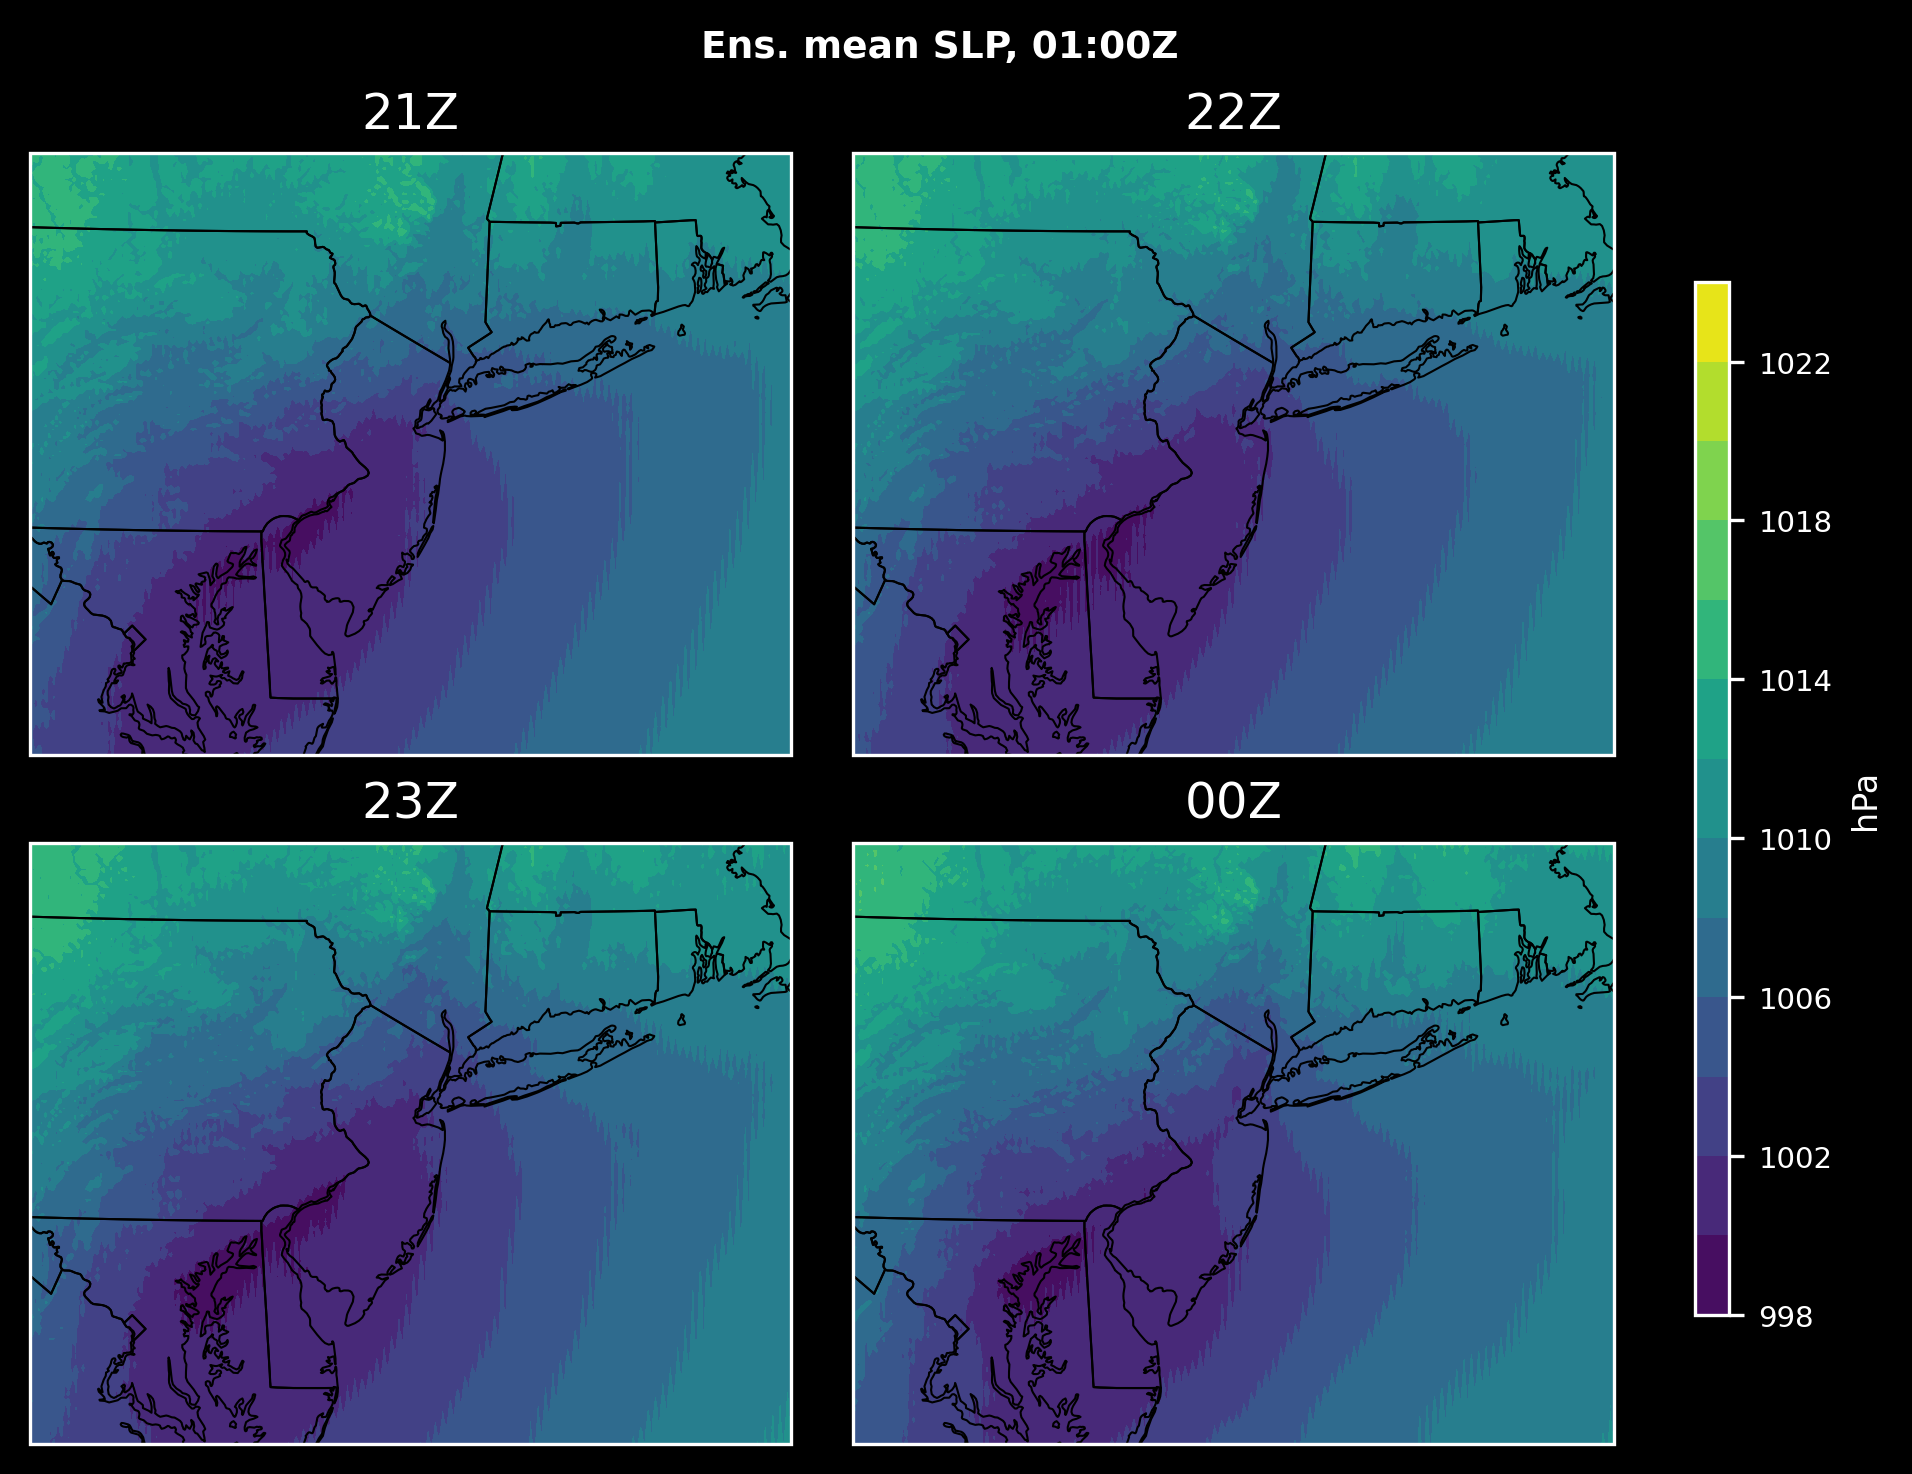

In [26]:
# define a few variables
linewidth=0.5
region = [-78,-70.7,38,42.5]
titles = ["21Z", "22Z", "23Z", "00Z"]

# Get data to plot
data_to_plot = [get_time(m,"2021-09-02 01:00:00").squeeze().mean(
    dim="ens"
) for m in mslp_list]

proj = ccrs.LambertConformal(central_longitude=central_longitude,
                             central_latitude=central_latitude)

fig, axes = plt.subplots(2, 2, subplot_kw=dict(projection=proj),
                         dpi=300,layout="constrained")

for i,ax in enumerate(axes.flatten()):
    c = ax.contourf(
        lon,lat,data_to_plot[i]/100,
        transform=ccrs.PlateCarree(),cmap='viridis',
        levels=np.arange(998,1025,2)
    )
    c.axes.set_extent(region,crs=ccrs.PlateCarree())
    c.axes.add_feature(cfeature.STATES,linewidth=linewidth)
    ax.set_title(titles[i])

plt.subplots_adjust(wspace=0.04,hspace=0.04)
plt.suptitle("Ens. mean SLP, 01:00Z",fontsize=9,fontweight='bold')
cbar = fig.colorbar(c,ax=axes,shrink=0.8,aspect=30)
cbar.ax.tick_params(labelsize=7)
cbar.set_label("hPa",fontsize=8)
plt.show()

In [27]:
psfc_21Z = xr.concat([fix_xtime(load("PSFC","21Z",e),"21") for e in range(1,19)],
                       "ens").PSFC


In [33]:
T2_21Z = xr.concat([fix_xtime(load("T2","21Z",e),"21") for e in range(1,19)],
                       "ens").T2

In [41]:
HGT_21Z = xr.concat([fix_xtime(load("HGT","21Z",e),"21") for e in range(1,19)],
                       "ens").HGT

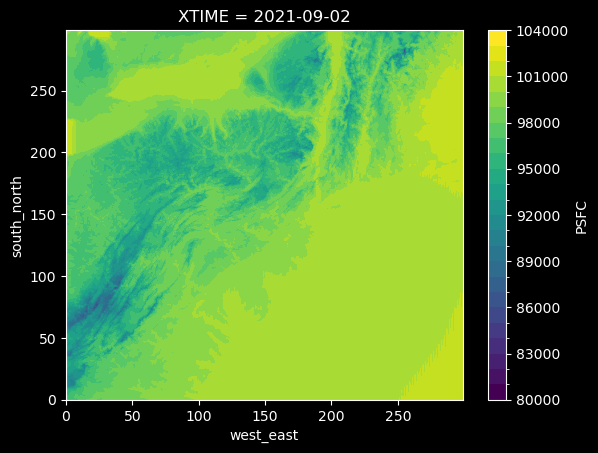

In [62]:
xr.plot.contourf(get_time(psfc_21Z,"2021-09-02 00:00:00").mean(dim="ens"),
levels=np.arange(80000,104001,1000))

In [23]:
xr.plot.contourf(get_time(T2_21Z,"2021-09-02 00:00:00").mean(dim="ens"))

NameError: name 'T2_21Z' is not defined

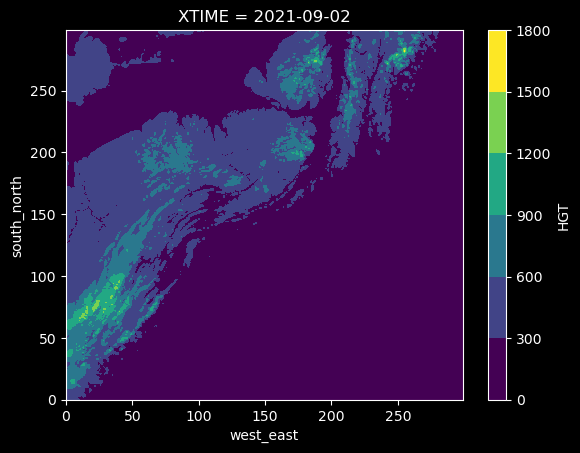

In [40]:
xr.plot.contourf(get_time(HGT,"2021-09-02 00:00:00").mean(dim="ens"))

In [42]:
HGT_21Z.units

'm'

In [55]:
stemps = T2_21Z+(6.5*HGT_21Z/1000)

In [61]:
mslp = psfc_21Z*np.exp(9.81/(287.0*stemps)*HGT_21Z)*0.01 + (6.7 * (HGT_21Z/1000)) 

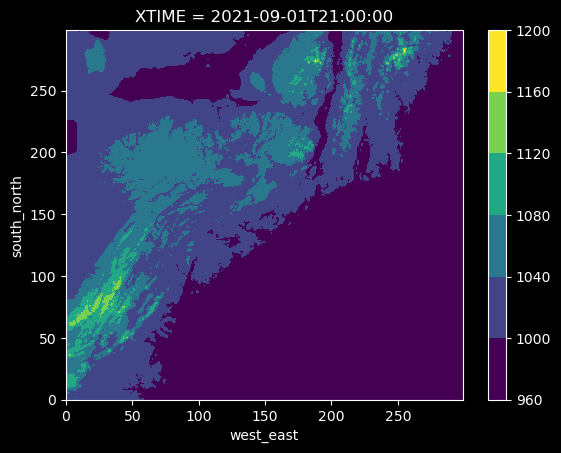

In [60]:
xr.plot.contourf(mslp.isel(Time=0).mean(dim="ens"))

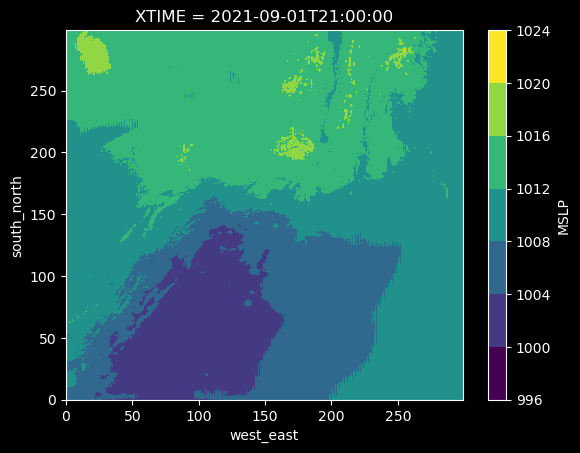

In [58]:
xr.plot.contourf((mslp_21Z/100).isel(Time=0).mean(dim="ens"))